<a href="https://colab.research.google.com/github/Usama113m/Jaudience-Project-Vivid-Vision-Ai/blob/main/Jaundice_Detection_Final(RGB_histogram_for_dark_skin).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imported librareis

In [26]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

Extract face using a pre-trained deep learning model

In [27]:
def skin_detection(image):
    # Convert to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab_image)

    # Apply OTSU thresholding
    _, A_thresh = cv2.threshold(A, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, B_thresh = cv2.threshold(B, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Combine thresholded channels
    skin_mask = cv2.bitwise_and(A_thresh, B_thresh)

    # Apply morphological operations to refine mask
    kernel = np.ones((5, 5), np.uint8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)

    # Apply mask to original image
    skin_region = cv2.bitwise_and(image, image, mask=skin_mask)
    return skin_region, skin_mask

In [28]:
def jaundice_detection(image):
    # Convert to YCrCb color space
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb_image)

    # Apply OTSU thresholding on Cb channel (yellow detection)
    _, Cb_thresh = cv2.threshold(Cb, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Calculate the yellow pixel percentage
    yellow_pixels = np.sum(Cb_thresh == 255)
    total_pixels = Cb_thresh.size
    yellow_percentage = (yellow_pixels / total_pixels) * 100

    # Determine if jaundice is detected based on threshold

    return yellow_percentage, Cb_thresh

In [29]:
def extract_features(roi):
    roi_resized = cv2.resize(roi, (50, 50))  # Normalize size
    roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
    roi_ycbcr = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2YCrCb)

    # Compute mean values for RGB and YCbCr color spaces
    R_mean = np.mean(roi_rgb[:, :, 0])  # Red channel mean
    G_mean = np.mean(roi_rgb[:, :, 1])  # Green channel mean
    B_mean = np.mean(roi_rgb[:, :, 2])  # Blue channel mean
    Y_mean = np.mean(roi_ycbcr[:, :, 0])  # Y channel mean
    Cb_mean = np.mean(roi_ycbcr[:, :, 1])  # Cb channel mean
    Cr_mean = np.mean(roi_ycbcr[:, :, 2])  # Cr channel mean

    # Feature vector
    features = np.array([R_mean, G_mean, B_mean, Y_mean, Cb_mean, Cr_mean]).reshape(1, -1)

    # Store data for visualization
    feature_data = {
        "Feature": ["Red Mean", "Green Mean", "Blue Mean", "Y Mean", "Cb Mean", "Cr Mean"],
        "Value": [R_mean, G_mean, B_mean, Y_mean, Cb_mean, Cr_mean]
    }
    df = pd.DataFrame(feature_data)
    return features, df, roi_rgb

In [30]:
def plot_rgb_histogram(roi_rgb):
    colors = ("red", "green", "blue")
    plt.figure(figsize=(8, 5))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([roi_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.title("RGB Histogram of ROI")
    plt.legend(["Red", "Green", "Blue"])
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


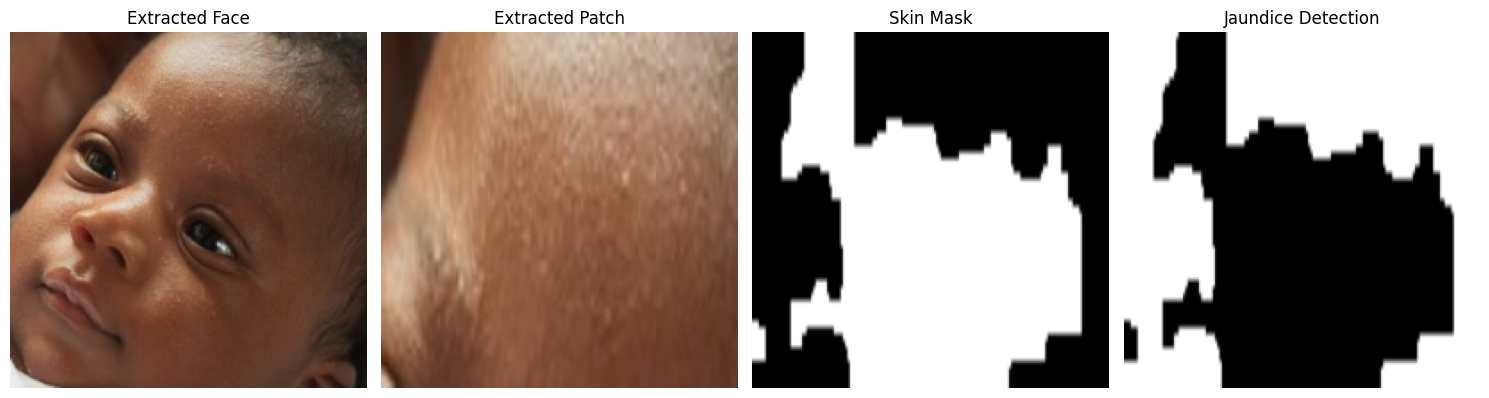

Yellow Pixel Percentage: 48.94%

Feature Values Table:
   Feature    Value
  Red Mean 151.7904
Green Mean 108.4468
 Blue Mean  82.9036
    Y Mean 118.4904
   Cb Mean 151.7792
   Cr Mean 107.9232


In [31]:
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

# Mount Google Drive
drive.mount('/content/drive')

# Define the image path
image_path = '/content/drive/MyDrive/images/baby3.jpg'
img = cv2.imread(image_path)

def extract_face_detect(image):
    net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel')
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Adjust confidence threshold as needed
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            return image[startY:endY, startX:endX], startX, startY, endX, endY  # Return face & coordinates

    return image, 0, 0, 0, 0  # Default return

# Extract the face and its coordinates (assuming extract_face_detect is defined elsewhere)
face_detect, fx, fy, ex, ey = extract_face_detect(img)

if face_detect is not None:
    h, w = face_detect.shape[:2]

    # Define the rectangle coordinates (Example: Forehead region)
    rect_x = int(0.25 * w)  # X offset
    rect_y = int(0.1 * h)  # Y offset (top of the face)
    rect_w = int(0.5 * w)  # Width of the patch
    rect_h = int(0.2 * h)  # Height of the patch

    # Crop the patch from the face
    face_patch = face_detect[rect_y:rect_y + rect_h, rect_x:rect_x + rect_w]

    # Save the patch
    cv2.imwrite("extracted_patch.jpg", face_patch)
else:
    print("Face not detected.")

# Assuming skin_detection, jaundice_detection, and extract_features are defined elsewhere
skin_region, skin_mask = skin_detection(face_patch)
yellow_percentage, Cb_thresh = jaundice_detection(skin_region)

# Resize all images to the same dimensions (optional, if needed)
def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

# Define the target size for all images
target_width, target_height = 200, 200  # Adjust as needed

# Resize images (if necessary)
face_detect_resized = resize_image(face_detect, target_width, target_height)
face_patch_resized = resize_image(face_patch, target_width, target_height)
skin_mask_resized = resize_image(skin_mask, target_width, target_height)
Cb_thresh_resized = resize_image(Cb_thresh, target_width, target_height)

# Convert BGR images to RGB for matplotlib
face_detect_rgb = cv2.cvtColor(face_detect_resized, cv2.COLOR_BGR2RGB)
face_patch_rgb = cv2.cvtColor(face_patch_resized, cv2.COLOR_BGR2RGB)
skin_mask_rgb = cv2.cvtColor(skin_mask_resized, cv2.COLOR_BGR2RGB)
Cb_thresh_rgb = cv2.cvtColor(Cb_thresh_resized, cv2.COLOR_BGR2RGB)

# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Display images in the grid
axes[0].imshow(face_detect_rgb)
axes[0].set_title("Extracted Face")
axes[0].axis('off')

axes[1].imshow(face_patch_rgb)
axes[1].set_title("Extracted Patch")
axes[1].axis('off')

axes[2].imshow(skin_mask_rgb, cmap='gray')
axes[2].set_title("Skin Mask")
axes[2].axis('off')

axes[3].imshow(Cb_thresh_rgb, cmap='gray')
axes[3].set_title("Jaundice Detection")
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Print additional results
print(f'Yellow Pixel Percentage: {yellow_percentage:.2f}%')

features, df, roi_rgb = extract_features(face_patch)
# result = rf_model.predict(features)[0]

# Generate table
print("\nFeature Values Table:")
print(df.to_string(index=False))

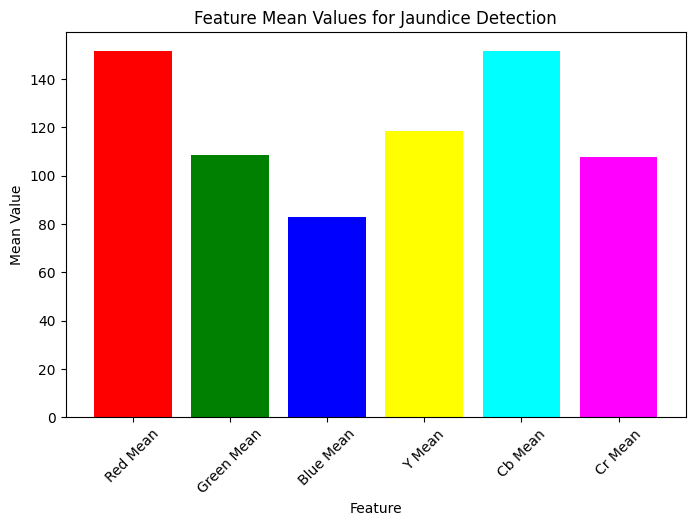

In [32]:
# Generate bar graph
plt.figure(figsize=(8, 5))
plt.bar(df["Feature"], df["Value"], color=['red', 'green', 'blue', 'yellow', 'cyan', 'magenta'])
plt.xlabel("Feature")
plt.ylabel("Mean Value")
plt.title("Feature Mean Values for Jaundice Detection")
plt.xticks(rotation=45)
plt.show()


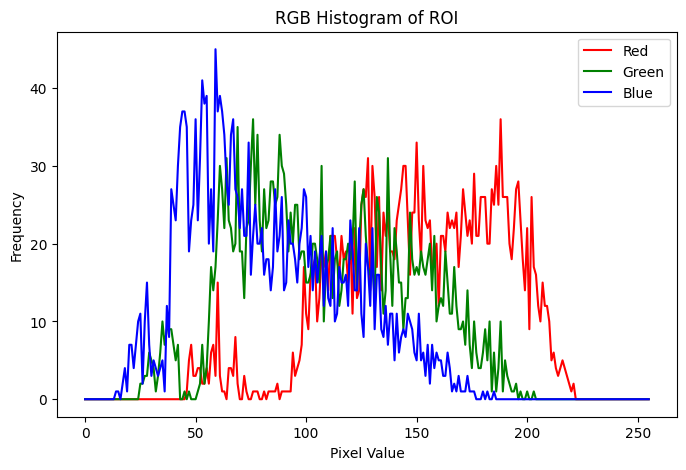

In [33]:
# Plot RGB histogram
plot_rgb_histogram(roi_rgb)